In [1]:
%matplotlib inline

In [2]:
air_data = spark.read.parquet('qfs://master:20000/user/michael/data/airline_data')
airlines = spark.read.parquet('qfs://master:20000/user/michael/data/airline_id_table')

In [3]:
from pyspark.sql.functions import avg, udf, col
from pyspark.sql.types import StringType

def getYearMonthStr(year, month):
    return '%d-%02d'%(year,month)

udfGetYearMonthStr = udf(getYearMonthStr, StringType())

airline_delay = air_data.select(
    'Carrier',
    'Year',
    'Month',
    'ArrDelay'
).filter(
    col('Carrier').isin('AA','WN','DL','UA','MQ','EV','AS','VX')
).groupBy(
    'Carrier',
    'Year',
    'Month'
).agg(
    avg(col('ArrDelay')).alias('average_delay')
).withColumn(
    'YearMonth', udfGetYearMonthStr('Year','Month')
).drop(
    'Year'
).drop(
    'Month'
).orderBy(
    'YearMonth','Carrier'
).cache()

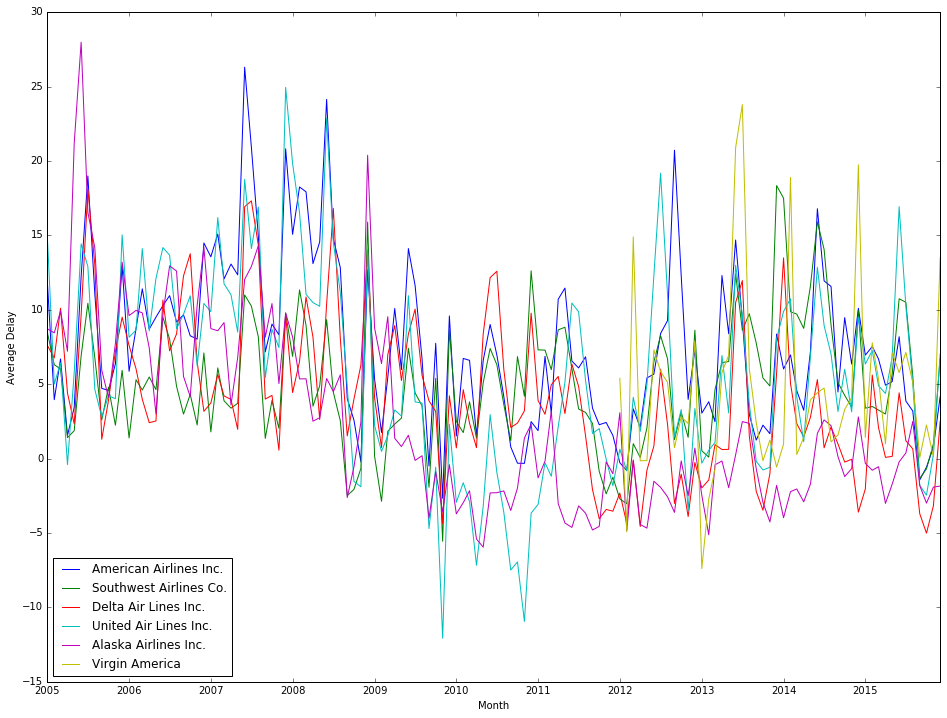

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

airline_delay_pd = airline_delay.toPandas()

carriers = ['AA','WN','DL','UA','AS','VX']

name_dict = airlines.filter(
    col('Carrier').isin('AA','WN','DL','UA','MQ','EV','AS','VX')
).select(
    'Carrier',
    'AirlineName'
).toPandas().set_index('Carrier')['AirlineName'].to_dict()

fig, ax = plt.subplots()

for carrier in carriers:
    carrier_data = airline_delay_pd[airline_delay_pd['Carrier']==carrier]
    dates_raw = carrier_data['YearMonth']
    dates = [dt.datetime.strptime(date,'%Y-%m') for date in dates_raw]
    ax.plot(dates, carrier_data['average_delay'], label = "{0}".format(name_dict[carrier]))

fig.set_size_inches(16,12)
plt.xlabel("Month")
plt.ylabel("Average Delay")
ax.legend(loc='lower left')
plt.show()

In [5]:
from pyspark.sql.functions import col, when, max

# convert the airline rows to columns

airlines = sorted(airline_delay.select(
        'Carrier'
    ).distinct().rdd.map(lambda row: row[0]).collect())

cols = [when(col('Carrier') == a, col('average_delay')).otherwise(None).alias(a) 
        for a in airlines]

maxs = [max(col(a)).alias(a) for a in airlines]

airline_delay_reformed = airline_delay.select(
        col("YearMonth"), 
        *cols
    ).groupBy(
        "YearMonth"
    ).agg(*maxs).na.fill(0).orderBy(
        'YearMonth'
    ).cache()

In [6]:
from pyspark.sql import DataFrameStatFunctions
import pandas as pd
import numpy as np

corr_data = dict(
        (
            a,
            [airline_delay_reformed.stat.corr(a,b) if a > b else np.nan for b in airlines]
        ) for a in airlines
    )
correlations_df = pd.DataFrame(corr_data, index=airlines)
print(correlations_df)

    AA        AS        DL        EV        MQ        UA        VX        WN
AA NaN  0.468001  0.580626  0.551466  0.718490  0.778896  0.029129  0.503715
AS NaN       NaN  0.526844  0.443933  0.345010  0.522625 -0.137774  0.192667
DL NaN       NaN       NaN  0.715151  0.571382  0.509096 -0.052562  0.480522
EV NaN       NaN       NaN       NaN  0.594915  0.600003  0.056209  0.485396
MQ NaN       NaN       NaN       NaN       NaN  0.647358  0.166137  0.656206
UA NaN       NaN       NaN       NaN       NaN       NaN  0.171475  0.517596
VX NaN       NaN       NaN       NaN       NaN       NaN       NaN  0.275750
WN NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN
